## **Classificador de imagens de gatos e cachorros**

Importando Bibliotecas

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Coletando os dados

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

# Criancao do caminho para o diretorio
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Coletando o numero de arquivos em cada diretorio
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variaveis para pré-processamento e treinamento
batch_size = 128
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/

Carregamento das imagens

In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

#Carregando imagens do diretorio
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size, #Numero de amostra
                                                     directory=train_dir, #Caminho do diretorio
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Tamanho para redimensonamento durante o carregamento das imagens
                                                     class_mode='binary') #Define o modo de classificação para as imagens
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=validation_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=PATH, classes=['test'],
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="input", shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


Vizualização de um conjunto de imagens de treinamento

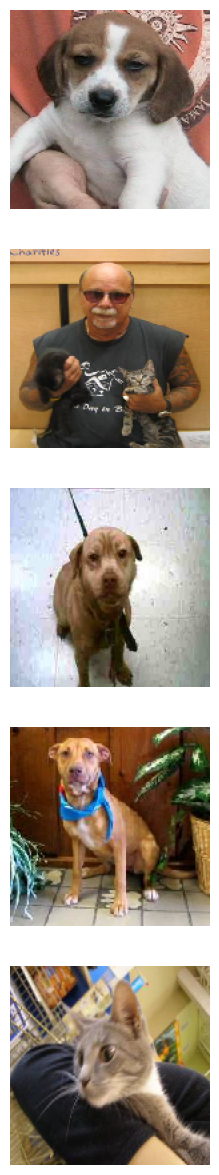

In [ ]:
# 4
#Funcao para exibir imagens
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

#Carrega um lote de imagens de treinamento
sample_training_images, _ = next(train_data_gen)
#Chama a funcao para exibir as 5 primeiras imagens do treinamento
plotImages(sample_training_images[:5])

Gerando variações nas imagens ajudando a evitar o overfitting (quando o modelo se ajusta excessivamente bem aos dados de treinamento, mas tem desempenho frace com novos dados) e melhorar a robustez do modelo ao apresentar diferentes perspectivas das imagens durante o treinamento

In [ ]:
# 5
train_image_generator = ImageDataGenerator(rescale=1/255,
                                           rotation_range = 15,
                                           height_shift_range = 0.2,
                                           width_shift_range = 0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2)


Carregamento das imagens de treinamento, com as variações em cada imagem, e exibição de cinco variações de uma imagem

Found 2000 images belonging to 2 classes.


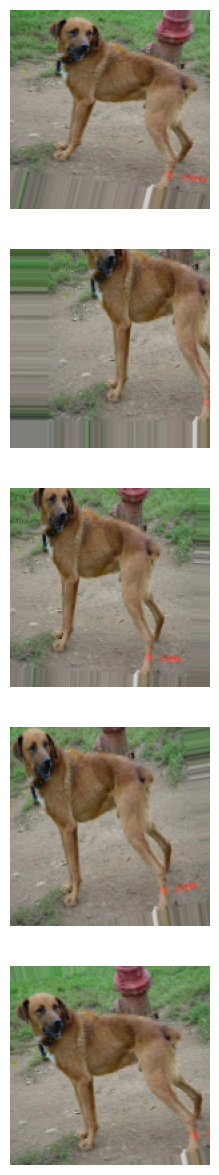

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

Criação do modelo de rede neural convolucional (CNN) usando a biblioteca Keras

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

# Compilando o modelo
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#resumo de modelo
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 73, 73, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 341056)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               43655296  
                                                      

Treinamento do modelo usando dados do treinamento e validação

In [ ]:
# 8
history = model.fit(train_data_gen, #Dados
                    steps_per_epoch=total_train//batch_size, #Numero de etapas
                    epochs=epochs, #Numero de epocas
                    validation_data=val_data_gen, #Dados de validação
                    validation_steps=total_val//batch_size, #Etapas consideradas como uma época de validação
                    verbose=1) #Exibir um indicador de progresso durante o treinamento

Epoch 1/100
15/15 [==============================] - 19s 1s/step - loss: 1.7404 - accuracy: 0.5069 - val_loss: 0.6755 - val_accuracy: 0.5469
Epoch 2/100
15/15 [==============================] - 18s 1s/step - loss: 0.6705 - accuracy: 0.5507 - val_loss: 0.6444 - val_accuracy: 0.5703
Epoch 3/100
15/15 [==============================] - 16s 1s/step - loss: 0.6534 - accuracy: 0.5929 - val_loss: 0.6474 - val_accuracy: 0.6027
Epoch 4/100
15/15 [==============================] - 16s 1s/step - loss: 0.6565 - accuracy: 0.5908 - val_loss: 0.6432 - val_accuracy: 0.5915
Epoch 5/100
15/15 [==============================] - 16s 1s/step - loss: 0.6390 - accuracy: 0.6223 - val_loss: 0.6319 - val_accuracy: 0.6362
Epoch 6/100
15/15 [==============================] - 16s 1s/step - loss: 0.6365 - accuracy: 0.6453 - val_loss: 0.6214 - val_accuracy: 0.6172
Epoch 7/100
15/15 [==============================] - 16s 1s/step - loss: 0.6334 - accuracy: 0.6362 - val_loss: 0.6281 - val_accuracy: 0.6283
Epoch 8/100
1

Criação dos gráficos para visualizar o desempenho do modelo durante o treinamento e validação ao longo das épocas

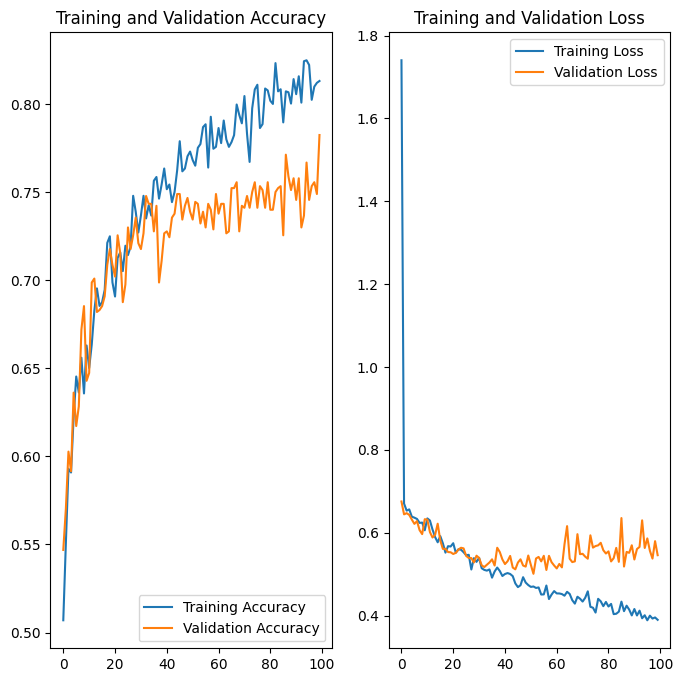

In [ ]:
acc = history.history['accuracy'] #Extrai a lista de accuracy de treinamento para cada época do histórico
val_acc = history.history['val_accuracy'] #Extrai a lista de accuracy de validação para cada época do histórico

loss = history.history['loss'] #Extrai a lista de perdas de treinamento para época do histórico
val_loss = history.history['val_loss'] #Extrai a lista de perdas de validação para época do histórico

epochs_range = range(epochs) #Cria uma sequencia de numeros representando as épocas de treinamento

#Crianção de um gráfico para accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treinamento Accuracy')
plt.plot(epochs_range, val_acc, label='Validação Accuracy')
plt.legend(loc='lower right')
plt.title('Treinamento e validação da Accuracy')

#Crianção de um gráfico para perdas
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treinamento Loss')
plt.plot(epochs_range, val_loss, label='Validação Loss')
plt.legend(loc='upper right')
plt.title('Treinamento e validação Loss')
plt.show()

Previsões usando o modelo de treinamento para o conjunto de dados teste, e exibição de uma amostra de 50 imagens do conjunto de treinamento junto com as probabilidades

1/1 [==============================] - 0s 179ms/step


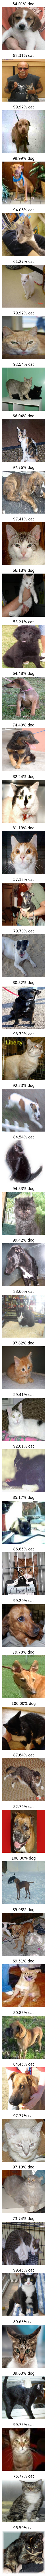

In [ ]:

  probabilities = model.predict(test_data_gen)

  plotImages(sample_training_images[:50], probabilities)

Avaliação do desempenho

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):

  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 82.0% of the images of cats and dogs.
You passed the challenge!
